# Market basket analysis using Apriori algorithm

Here we attempt to group common patterns of items together using Association rules using Apriori algorithm.

Association rules do not extract an individual's preference, rather find relationships between sets of elements of every distinct transaction.

Metrics useful for MBA:

1) Support: % of times when Milk & Butter were purchased. <br>
<br>
(No.of transactions having Milk & Butter / Total No. of transactions) in % <br>
2) Confidence: Whats the probability % of Butter in basket provided Milk in basket ? <br>
<br>
Confidence(Butter -> Milk) = (support(Milk U Butter)/ support(Butter) remember this is not equal to Confidence(Milk, Butter) Ranges from 0 (No relation) to 1 (High relation) in % <br>
3) Lift: How much will sale of Butter increase when you sell Milk or vice versa ? <br>
<br>
Lift{Milk, Butter} = Lift{Butter,Milk} = support(Milk U Butter)/ support(Milk) * support(Butter) Ranges from 1 (No relationship) to 1> Negative relationship, 1< Positive relationship <br>
<br>
4) Conviction: What is your conviction to purchase product 2 provided you have purchased product 1? <br>
<br>
High value, higher chances of purchasing product 2 <br>
Conviction{Trousers -> Belt} = 2.614 <br>
Conviction{Shirts -> Belt} = 0.86 <br>

In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
data = pd.read_csv('olist_order_items_dataset.csv')
data = data.head(30000) #using only half data due to memory issues
data.head()

,order_id,order_item_id,product_id,product_id2,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,P13599,48436dade18ac8b2bce089ec2a041202,9/19/2017 9:45,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,P32302,dd7ddc04e1b6c2c614352b383efe2d36,5/3/2017 11:05,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,P11296,5b51032eddd242adc84c38acab88f23d,1/18/2018 14:48,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,P01401,9d7a1d34a5052409006425275ba1c2b4,8/15/2018 10:10,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,P17461,df560393f3a51e74553ab94004ba5c87,2/13/2017 13:57,199.90,18.14


In [3]:
data.shape

(30000, 8)

In [4]:
data.order_id.unique().shape

(26222,)

In [5]:
data.insert(8, 'quantity',1)
data.shape

(30000, 9)

In real world scenarios, you will receive data in this format with every product within an order given in separate rows. We have to find the relation between 2 or more products frequently appearing together. We can't use this data the way it is, we got to further convert this into a format that is accepted by Apriori algorithm.

# Data Preprocessing

Things to do:

Total no. of unique orders and products
Whether to drop products that are purchased within a given threshold
Average no. of products purchased in a given order

1) Total no. of unique orders and products<br>
2) Whether to drop products that are purchased within a given threshold<br>
3) Average no. of products purchased in a given order<br>

In [6]:
data.describe(include = 'all')

,order_id,order_item_id,product_id,product_id2,seller_id,shipping_limit_date,price,freight_value,quantity
count,30000,30000.000000,30000,30000,30000,30000,30000.000000,30000.000000,30000.0
unique,26222,NaN,13837,13837,2267,20662,NaN,NaN,NaN
top,1b15974a0141d54e36626dca3fdc731a,NaN,422879e10f46682990de24d770e7f83d,P28011,6560211a19b47992c3666cc44a7e94c0,2/27/2018 3:31,NaN,NaN,NaN
freq,20,NaN,137,137,553,22,NaN,NaN,NaN
mean,NaN,1.202667,NaN,NaN,NaN,NaN,120.894465,20.048084,1.0
std,NaN,0.722918,NaN,NaN,NaN,NaN,187.854795,16.037283,0.0
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.850000,0.000000,1.0
25%,NaN,1.000000,NaN,NaN,NaN,NaN,39.900000,13.010000,1.0
50%,NaN,1.000000,NaN,NaN,NaN,NaN,74.900000,16.280000,1.0
75%,NaN,1.000000,NaN,NaN,NaN,NaN,134.900000,21.222500,1.0


If your dataset has a count of order numbers as huge as 1 million, then you can choose to drop some products that were purchased just once or below some threshold. Here I would take a threshold of 10. This would ensure not to overburden the system while giving you the best results.

No point in deriving relations out of products that were rarely purchased, right.

In [7]:
data['product_id'].value_counts()

422879e10f46682990de24d770e7f83d    137
aca2eb7d00ea1a7b8ebd4e68314663af    130
99a4788cb24856965c36a24e339b6058    125
368c6c730842d78016ad823897a372db    113
389d119b48cf3043d311335e499d9c6b    104
                                   ... 
2da8e82c3ddd9c8f784930f7d2db4d34      1
6023859c9a1cfdb91a9d035c7b2a8121      1
e0902552451db4cf3f7b63863276f24a      1
7f04dc0b85182744b422109acd2d40f5      1
f0ea71b6e2ab4cb3bd8f5ba522a25a56      1
Name: product_id, Length: 13837, dtype: int64

In [8]:
data['product_id2'].value_counts()

P28011    137
P16646    130
P06326    125
P12927    113
P25745    104
         ... 
P32862      1
P01263      1
P25977      1
P00911      1
P18800      1
Name: product_id2, Length: 13837, dtype: int64

In [9]:
#If you want to cross check the data you can replace 10 with 80.
item_freq = data['product_id2'].value_counts()
data = data[data.isin(item_freq.index[item_freq >= 10]).values]
data['product_id2'].value_counts()

P28011    137
P16646    130
P06326    125
P12927    113
P25745    104
         ... 
P05044     10
P04945     10
P30455     10
P25965     10
P30224     10
Name: product_id2, Length: 329, dtype: int64

In [61]:
data.to_csv('varad.csv')

In [10]:
data['product_id2'] = data['product_id2'].astype(str)

In [11]:
data['product_id2'] = data['product_id2'].replace(['P05548'],'Garden Hose')
data['product_id2'] = data['product_id2'].replace(['P25745'],'Common Garden Rake')
data['product_id2'] = data['product_id2'].replace(['P28011'],'24-Tine Steel Rake')
data['product_id2'] = data['product_id2'].replace(['P12927'],'Stand-up Weeder')
data['product_id2'] = data['product_id2'].replace(['P03185'],'15-Tine Forged Bow')

In [27]:
data.loc[data['product_id2'] == 'Garden Hose']

,order_id,order_item_id,product_id,product_id2,seller_id,shipping_limit_date,price,freight_value,quantity
499,0124e0c5bfae1979838a91e47df53f14,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,2/14/2018 16:31,49.9,12.48,1
1792,04116cd1278a6285625c664dc0d09594,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,12/4/2017 3:31,49.0,17.64,1
2656,05f54a9f4abf370b7c655d914159ab98,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,4/5/2018 23:27,53.9,13.46,1
6945,0fb5a3160f044b869ebab3a1d50f0471,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,9/8/2017 6:41,59.9,28.82,1
10271,178ca782e5105b917275138274960c52,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,10/18/2017 10:20,59.9,17.67,1
10410,17ccd767f82739a919e20ae38fb692d8,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,2/6/2018 18:10,49.9,17.60,1
10808,189ce876121fdc47b810933fb0b4f4bd,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,11/30/2017 20:37,49.0,17.64,1
11608,1a611328643ae11146ba09a4425d2e12,1,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,5/8/2018 23:54,53.9,16.07,1
12649,1cb61aaa63135f552055cf1932adf3be,2,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,5/2/2018 21:30,53.9,17.34,1
12650,1cb61aaa63135f552055cf1932adf3be,3,0bcc3eeca39e1064258aa1e932269894,Garden Hose,1f50f920176fa81dab994f9023523100,5/2/2018 21:30,53.9,17.34,1


In [28]:
data.to_csv('varadfinal.csv')

In [12]:
#Average products purchased per transaction
data['order_id'].value_counts().mean()

1.154075546719682

In [13]:
#Create a basket of all products, orders and quantity
basket = (data.groupby(['order_id','product_id2'])['quantity']).sum().unstack().reset_index().fillna(0).set_index('order_id')
basket.head()

product_id2,15-Tine Forged Bow,24-Tine Steel Rake,Common Garden Rake,Garden Hose,P00234,P00295,P00580,P00583,P00612,P00619,...,P32291,P32415,P32443,P32539,P32673,P32754,P32809,P32817,P32902,Stand-up Weeder
order_id,,,,,,,,,,,,,,,,,,,,,
00061f2a7bc09da83e415a52dc8a4af1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006ec9db01a64e59a68b2c340bf65a7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0008288aa423d2a3f00fcb17cd7d8719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
00130c0eee84a3d909e75bc08c5c3ca1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0015ebb40fb17286bea51d4607c4733c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def encode_units(x):
    if x<= 0:
        return 0
    if x>=1:
        return 1
    
basket_sets = basket.applymap(encode_units)
basket_sets.head()

product_id2,15-Tine Forged Bow,24-Tine Steel Rake,Common Garden Rake,Garden Hose,P00234,P00295,P00580,P00583,P00612,P00619,...,P32291,P32415,P32443,P32539,P32673,P32754,P32809,P32817,P32902,Stand-up Weeder
order_id,,,,,,,,,,,,,,,,,,,,,
00061f2a7bc09da83e415a52dc8a4af1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0006ec9db01a64e59a68b2c340bf65a7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008288aa423d2a3f00fcb17cd7d8719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
00130c0eee84a3d909e75bc08c5c3ca1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0015ebb40fb17286bea51d4607c4733c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Recommend similar products using Apriori

Things to do: <br>
<br>
Create a basket of all products, orders and quantity<br>
Perform One hot encoding so as to convert all quantities into format suitable for apriori algorithm <br>
Build list of frequent itemsets <br>
Generate rules based on your requirements <br>

In [15]:
#Build frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.0001, use_colnames = True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.012757,(15-Tine Forged Bow),1
1,0.017396,(24-Tine Steel Rake),1
2,0.013917,(Common Garden Rake),1
3,0.003479,(Garden Hose),1
4,0.001160,(P00234),1
...,...,...,...
373,0.000166,"(Garden Hose, 24-Tine Steel Rake, 15-Tine Forg...",3
374,0.000166,"(Garden Hose, Common Garden Rake, 15-Tine Forg...",3
375,0.000166,"(Garden Hose, Stand-up Weeder, 15-Tine Forged ...",3
376,0.000166,"(Garden Hose, 24-Tine Steel Rake, Common Garde...",3


In [16]:
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.0001)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(24-Tine Steel Rake),(15-Tine Forged Bow),0.017396,0.012757,0.000166,0.009524,0.746568,-0.000056,0.996736
1,(15-Tine Forged Bow),(24-Tine Steel Rake),0.012757,0.017396,0.000166,0.012987,0.746568,-0.000056,0.995533
2,(Common Garden Rake),(15-Tine Forged Bow),0.013917,0.012757,0.000663,0.047619,3.732839,0.000485,1.036605
3,(15-Tine Forged Bow),(Common Garden Rake),0.012757,0.013917,0.000663,0.051948,3.732839,0.000485,1.040115
4,(Garden Hose),(15-Tine Forged Bow),0.003479,0.012757,0.000331,0.095238,7.465677,0.000287,1.091164
...,...,...,...,...,...,...,...,...,...
125,"(Common Garden Rake, 15-Tine Forged Bow)","(Garden Hose, 24-Tine Steel Rake)",0.000663,0.000166,0.000166,0.250000,1509.000000,0.000166,1.333112
126,(Garden Hose),"(24-Tine Steel Rake, Common Garden Rake, 15-Ti...",0.003479,0.000166,0.000166,0.047619,287.428571,0.000165,1.049826
127,(24-Tine Steel Rake),"(Garden Hose, Common Garden Rake, 15-Tine Forg...",0.017396,0.000166,0.000166,0.009524,57.485714,0.000163,1.009448
128,(Common Garden Rake),"(Garden Hose, 24-Tine Steel Rake, 15-Tine Forg...",0.013917,0.000166,0.000166,0.011905,71.857143,0.000163,1.011881


In [17]:
rules[rules['confidence'] >= 0.50]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(24-Tine Steel Rake, 15-Tine Forged Bow)",(Common Garden Rake),0.000166,0.013917,0.000166,1.0,71.857143,0.000163,inf
92,"(Garden Hose, 24-Tine Steel Rake)",(15-Tine Forged Bow),0.000166,0.012757,0.000166,1.0,78.389610,0.000164,inf
93,"(Garden Hose, 15-Tine Forged Bow)",(24-Tine Steel Rake),0.000331,0.017396,0.000166,0.5,28.742857,0.000160,1.965209
94,"(24-Tine Steel Rake, 15-Tine Forged Bow)",(Garden Hose),0.000166,0.003479,0.000166,1.0,287.428571,0.000165,inf
98,"(Garden Hose, Common Garden Rake)",(15-Tine Forged Bow),0.000166,0.012757,0.000166,1.0,78.389610,0.000164,inf
99,"(Garden Hose, 15-Tine Forged Bow)",(Common Garden Rake),0.000331,0.013917,0.000166,0.5,35.928571,0.000161,1.972167
104,"(Garden Hose, Stand-up Weeder)",(15-Tine Forged Bow),0.000166,0.012757,0.000166,1.0,78.389610,0.000164,inf
105,"(Garden Hose, 15-Tine Forged Bow)",(Stand-up Weeder),0.000331,0.014414,0.000166,0.5,34.689655,0.000161,1.971173
110,"(Garden Hose, 24-Tine Steel Rake)",(Common Garden Rake),0.000166,0.013917,0.000166,1.0,71.857143,0.000163,inf
111,"(Garden Hose, Common Garden Rake)",(24-Tine Steel Rake),0.000166,0.017396,0.000166,1.0,57.485714,0.000163,inf


In [18]:
rulesconf = rules[rules['confidence'] >= 0.50]

In [19]:
rulesconf.sort_values('confidence', ascending=False, inplace=True)

C:\Users\rachc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
rulesconf.reset_index()

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,87,"(24-Tine Steel Rake, 15-Tine Forged Bow)",(Common Garden Rake),0.000166,0.013917,0.000166,1.0,71.857143,0.000163,inf
1,92,"(Garden Hose, 24-Tine Steel Rake)",(15-Tine Forged Bow),0.000166,0.012757,0.000166,1.0,78.389610,0.000164,inf
2,121,"(Garden Hose, Common Garden Rake)","(24-Tine Steel Rake, 15-Tine Forged Bow)",0.000166,0.000166,0.000166,1.0,6036.000000,0.000166,inf
3,120,"(Garden Hose, 24-Tine Steel Rake)","(Common Garden Rake, 15-Tine Forged Bow)",0.000166,0.000663,0.000166,1.0,1509.000000,0.000166,inf
4,119,"(24-Tine Steel Rake, Common Garden Rake, 15-Ti...",(Garden Hose),0.000166,0.003479,0.000166,1.0,287.428571,0.000165,inf
5,118,"(Garden Hose, Common Garden Rake, 15-Tine Forg...",(24-Tine Steel Rake),0.000166,0.017396,0.000166,1.0,57.485714,0.000163,inf
6,117,"(Garden Hose, 24-Tine Steel Rake, 15-Tine Forg...",(Common Garden Rake),0.000166,0.013917,0.000166,1.0,71.857143,0.000163,inf
7,116,"(Garden Hose, 24-Tine Steel Rake, Common Garde...",(15-Tine Forged Bow),0.000166,0.012757,0.000166,1.0,78.389610,0.000164,inf
8,111,"(Garden Hose, Common Garden Rake)",(24-Tine Steel Rake),0.000166,0.017396,0.000166,1.0,57.485714,0.000163,inf
9,110,"(Garden Hose, 24-Tine Steel Rake)",(Common Garden Rake),0.000166,0.013917,0.000166,1.0,71.857143,0.000163,inf


# PREPARATION FOR VISUAL

In [21]:
rulesconf.shape

(18, 9)

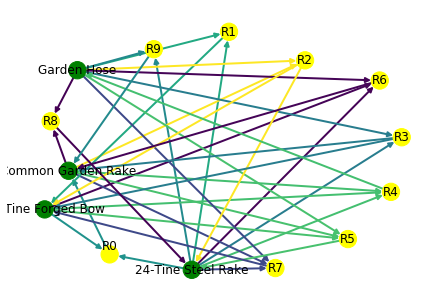

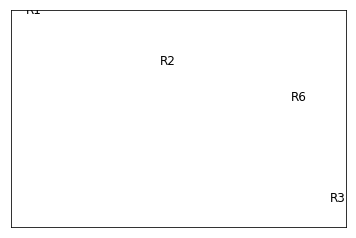

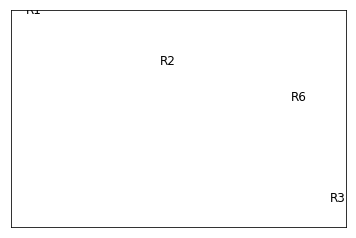

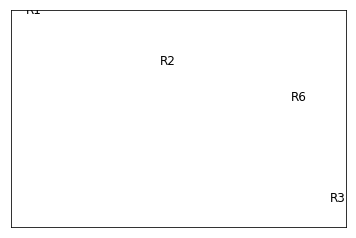

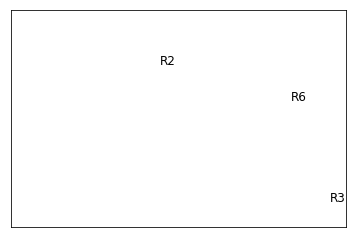

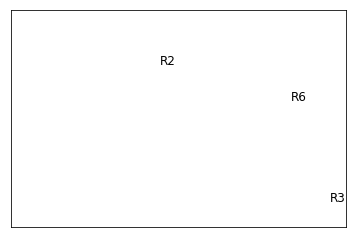

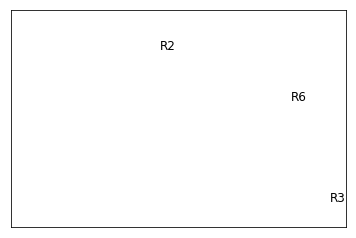

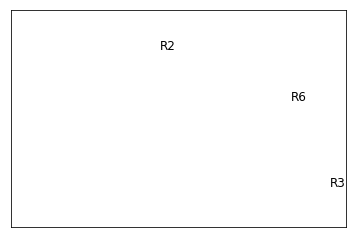

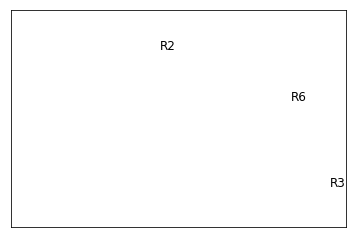

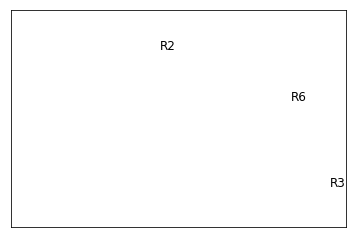

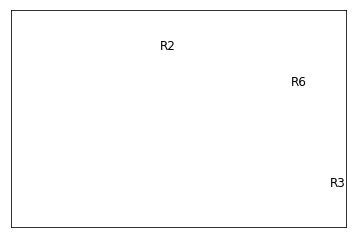

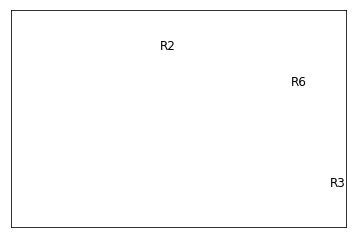

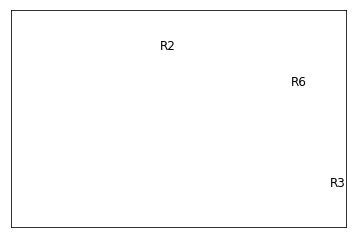

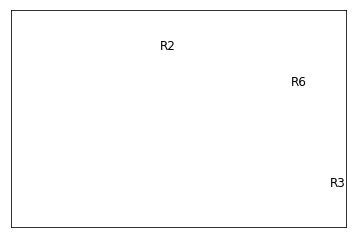

In [26]:
import networkx as nx
import matplotlib.pyplot as plt  
%matplotlib inline

def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17']

    for i in range(rules_to_show):
        G1.add_nodes_from(["R"+str(i)])
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       

    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, 
            with_labels=False)            

    for p in pos:  # raise text positions
        pos[p][1] += 0.07
        nx.draw_networkx_labels(G1, pos)
        #plt.figsize(32,10)
        plt.show()

draw_graph (rulesconf, 10)

In [38]:
rulesconfcopy = rulesconf.copy()

In [51]:
rulesconfcopy.reset_index(drop=True, inplace=True)

In [52]:
rulesconfcopy

,antecedents,consequents,confidence
0,"(24-Tine Steel Rake, 15-Tine Forged Bow)",(Common Garden Rake),1.0
1,"(Garden Hose, 24-Tine Steel Rake)",(15-Tine Forged Bow),1.0
2,"(Garden Hose, Common Garden Rake)","(24-Tine Steel Rake, 15-Tine Forged Bow)",1.0
3,"(Garden Hose, 24-Tine Steel Rake)","(Common Garden Rake, 15-Tine Forged Bow)",1.0
4,"(24-Tine Steel Rake, Common Garden Rake, 15-Ti...",(Garden Hose),1.0
5,"(Garden Hose, Common Garden Rake, 15-Tine Forg...",(24-Tine Steel Rake),1.0
6,"(Garden Hose, 24-Tine Steel Rake, 15-Tine Forg...",(Common Garden Rake),1.0
7,"(Garden Hose, 24-Tine Steel Rake, Common Garde...",(15-Tine Forged Bow),1.0
8,"(Garden Hose, Common Garden Rake)",(24-Tine Steel Rake),1.0
9,"(Garden Hose, 24-Tine Steel Rake)",(Common Garden Rake),1.0


In [53]:
rulesconfcopy.to_csv('rulesconfidence.csv')